# Modeling flow in ear aqueduct

* This demo is a modified version of https://github.com/CUQI-DTU/CUQIpy-demos/blob/main/training/Exercise05_PDE.ipynb

Here we build a Bayesian inverse problem in which the forward model is a partial differential equation (PDE) model, a 1D time-dependent diffusion Bayesain inverse problem in particular.

##  1. Import required libraries

We first import the required python standard packages that we need:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

From CUQIpy we import the classes that we use in this demo:

In [ ]:
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, Discrete, MappedGeometry, Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from cuqi.sampler import CWMH, MetropolisHastings
from cuqi.array import CUQIarray
np.random.seed(1)

## 2. Create the 1D diffusion PDE using the `TimeDependentLinearPDE` class 

### 2.1 The PDE model 
The PDE model is a one dimensional (1D) time-dependent diffusion PDE with Dirichlet boundary conditions.
The PDE is given by:

$$ \frac{\partial u(\xi,\tau)}{\partial t} - c \Delta_\xi u(\xi,\tau)   = f(\xi,\tau), \;\text{in}\;[0,400] $$
$$u(0,\tau)= g(\tau) $$
$$u(400,\tau)= 0 $$

where $u(\xi,\tau)$ is the tracer concentration and $c$ is the diffusion coefficient. We assume the source term $f$ is zero.

The model is discretized using finite differences in space and backward Euler in time.

### 2.2 The inverse problem 

The unknown parameters for the inverse problem we consider is the  diffusion coefficient $c$. We infer $c$ from the data $y$: concentration measurements at selected locations and times (corrupted by Gaussian noise as measurement error).

We build the spatial grid for the 1D heat model

In [ ]:
L = 400
n_grid = 100   # Number of solution nodes
h = L/(n_grid+1)   # Space step size
grid = np.linspace(h, L-h, n_grid)

Define the time steps

In [ ]:
tau_max = 30*60 # Final time in sec
cfl = 5 # The cfl condition to have a stable solution
         # the method is implicit, we can choose relativley large time steps 
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)

f, c and FD diffusion operator

In [ ]:
initial_condition = np.zeros(n_grid)
plt.plot(grid, initial_condition)
plt.title('Initial condition')
plt.xlabel('Distance')

c_exact = np.sqrt(600)
# Source term
def g(c, tau_current):
    f_array = np.zeros(n_grid)
    f_array[0] = c/h**2*100*np.sin(np.pi*tau_current/tau_max)
    return f_array

# plot f
plt.figure()
f_evaluated = [g(c_exact, t_c)[0] for t_c in tau]
plt.plot(tau, f_evaluated)
plt.xlabel('Time (sec)')
plt.title('left boundary')

D_c = lambda c: c * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2

PDE form:

In [ ]:
def PDE_form(c, tau_current):
    return (D_c(c), g(c, tau_current), initial_condition)


Create the `TimeDependentLinearPDE`

In [ ]:
grid_obs = np.array([10, 72.11102551, 144.222051, 229.0748648, 303.9080125])
time_obs = np.array([0, 5*60, 10*60, 15*60, 20*60, 25*60, 30*60])
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid,
                             method='backward_euler', 
                             grid_obs=grid_obs,
                            time_obs=time_obs)    
                             


In [ ]:
PDE

## 3. Create CUQIpy forward model using the `PDEModel` class


In [ ]:
# Domain geometry
G_D =  MappedGeometry( Discrete(1),  map=lambda x: x**2 )

# Range geometry
G_cont2D = Continuous2D((grid_obs, time_obs))

 Prepare model

In [ ]:
A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_D)

## 4. Exact solution and exact data:

### 4.1 Set up the exact solution
The exact solution of the Bayesian inverse problem 

In [ ]:
x_custom = CUQIarray(c_exact, is_par=True,
                    geometry=G_D)

In [ ]:
print("exact solution: ", x_custom.funvals)

### 4.2 Generate the exact data

In [ ]:
y_custom= A(x=x_custom)

## 5. Set up the Bayesian inverse problem

The joint distribution of the data $y$ and the parameter $x$ is given by

$$p(x,y) = p(y|x)p(x)$$



Where $p(x)$ is the prior pdf, $p(y|x)$ is the data distribution pdf (likelihood). 

### 5.1 Create the prior distribution

Create a Gaussian prior distribution 

In [ ]:
x = Gaussian(np.sqrt(400), 100, geometry=G_D)
x

Now samples from the prior will look like:

In [ ]:
x_samples = x.sample(20)

plt.figure()
x_samples.plot()


plt.figure()
x_samples.plot(is_par=True, plot_par=True)

### 5.2 Create the data distribution
To define the data distribution $p(y|x)$, we first estimate the noise level. Because here we know the exact data, we can estimate the noise level as follows:

In [ ]:
noise_level = 0.05
s_noise =1.0/np.sqrt(n_grid)* noise_level*np.linalg.norm(y_custom)

And then define the data distribution $p(y|x)$: 

In [ ]:
y = Gaussian(A(x), s_noise**2, geometry=G_cont2D)

### 5.3 Generate noisy data

In [ ]:
y_obs = y(x = x_custom).sample()

In [ ]:
color = ['r', 'g', 'b', 'k', 'm']
legends = ['loc = '+str(obs) for obs in grid_obs]
lines = []
for i in range(y_custom.funvals.shape[0]):
    #plt.figure()
    lines.append(plt.plot(time_obs/60, y_custom.funvals[i,:], color=color[i])[0])
    plt.plot(time_obs/60, y_obs.funvals[i,:], 'o', color=color[i])
    #plt.title('loc = '+str(i))

plt.legend(lines, legends)
plt.xlabel('Time (min)')
plt.ylabel('Concentration')



### 5.4 Specify the Bayesian model
Now that we have all the components we need, we can create the joint distribution $p(x,y)$, from which the posterior distribution can be created by setting $y=y_\text{obs}$:

First, we define the joint distribution $p(x,y)$:

In [ ]:
joint = JointDistribution(x, y)
joint

The posterior distribution pdf is given by the Bayes rule:
$$ p(x|y=y_\text{obs}) \propto p(y=y_\text{obs}|x)p(x) $$ 
By setting `y=y_obs` in the joint distribution we obtain the posterior distribution:

In [ ]:
posterior = joint(y=y_obs) # condition on y=y_obs
posterior

### 5.5 Specify the sampler and sample the posterior distribution 

In [ ]:
my_sampler = MetropolisHastings(posterior, scale=10, x0=20)

Sampling

In [ ]:
Ns = 5000  
posterior_samples = my_sampler.sample_adapt(Ns)

### 5.6 Visualize the results 

Plot the parameter $95\%$ credible interval

In [ ]:
plt.figure()
burn_ratio = 0.4
posterior_samples.burnthin(int(Ns*burn_ratio)).plot_ci(95, plot_par=True, exact=x_custom)

Plot the function values $95\%$ credible interval

In [ ]:
plt.figure()
posterior_samples.burnthin(int(Ns*burn_ratio)).plot_ci(95, exact=x_custom)

In [ ]:
plt.figure()
posterior_samples.burnthin(int(Ns*burn_ratio)).funvals.plot_ci(95, exact=x_custom)

In [ ]:
posterior_samples.burnthin(int(Ns*burn_ratio)).funvals.plot_trace()

## 6 We rerun the code but using real data this time

In [ ]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, Discrete, MappedGeometry, Continuous2D, Image2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel, Model
from cuqi.sampler import CWMH, MetropolisHastings
from cuqi.array import CUQIarray
np.random.seed(1)

df = pd.read_excel('~/Documents/research_resources/brain_efflux/CT_example_20210120_m1_l.xlsx')

data = df.loc[range(7)][['CA1', 'CA2', 'CA3', 'CA4', 'CA5']].values.T
print(data)
times = df.loc[range(7)]['time \ ROI'].values*60
print(times)
locations = df.loc[7][['CA1', 'CA2', 'CA3', 'CA4', 'CA5']].values
print(locations)

L = 400
n_grid = 100   # Number of solution nodes
h = L/(n_grid+1)   # Space step size
grid = np.linspace(h, L-h, n_grid)

tau_max = 30*60 # Final time in sec
cfl = 5 # The cfl condition to have a stable solution
         # the method is implicit, we can choose relativley large time steps 
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)

c_exact = np.sqrt(600)
# Source term
def g(c, tau_current):
    f_array = np.zeros(n_grid)
    f_array[0] = c/h**2*100*np.sin(np.pi*tau_current/tau_max)
    return f_array


D_c = lambda c: c * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2

initial_condition = np.zeros(n_grid) 

def PDE_form(c, tau_current):
    return (D_c(c), g(c, tau_current), initial_condition)

#grid_obs = np.array([10, 72.11102551, 144.222051, 229.0748648, 303.9080125])
#time_obs = np.array([0, 5*60, 10*60, 15*60, 20*60, 25*60, 30*60])
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid,
                             method='backward_euler', 
                             grid_obs=locations,
                            time_obs=times) 


# Domain geometry
G_D =  MappedGeometry( Discrete(1),  map=lambda x: x**2 )

# Range geometry
G_cont2D = Continuous2D((locations, times))


A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_D)


x = Gaussian(np.sqrt(400), 100, geometry=G_D)
s_noise = 0.1 \
          *np.linalg.norm(data) \
          *np.sqrt(1/G_cont2D.par_dim) 
y = Gaussian(A(x), s_noise**2, geometry=G_cont2D)

# Plot data 
color = ['r', 'g', 'b', 'k', 'm']
legends = ['loc = '+str(obs) for obs in locations]
lines = []
for i in range(len(locations)):
    #plt.figure()
    lines.append(plt.plot(times/60, data[i,:],  color=color[i])[0])
    #plt.plot(times/60, data[i,:], 'o', color=color[i])
    #plt.title('loc = '+str(i))

plt.legend(lines, legends)
plt.xlabel('Time (min)')
plt.ylabel('Concentration')

joint = JointDistribution(x, y)
joint

data = CUQIarray(data.ravel(), geometry=G_cont2D)
posterior = joint(y=data) # condition on y=y_obs
posterior

my_sampler = MetropolisHastings(posterior, scale=10, x0=20)

Ns = 10  # funval of mean is about 587.25403559
posterior_samples = my_sampler.sample_adapt(Ns)



## 7 Spatially varying diffusivity  

[   0.  300.  600.  900. 1200. 1500. 1800.]
[  0.          72.11102551 144.22205102 229.07486476 303.9080125 ]
[[-149.927 2597.44  6013.49  4446.09  1985.62  1234.37   940.252]
 [ 425.233 2275.54  5384.64  3816.14  1855.32  1097.27   992.281]
 [ 172.268 2185.24  4350.65  3313.73  1352.79  1112.86   830.461]
 [ 151.881 1615.86  2798.33  2481.57  1173.89   703.299  621.922]
 [ -66.724  917.614 2423.85  2160.31   865.628  887.841  789.56 ]]
Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using Linear_RTO may not produce fully accurate results.
Sample 5000 / 5000

Average acceptance rate all components: 0.43398431372549023 



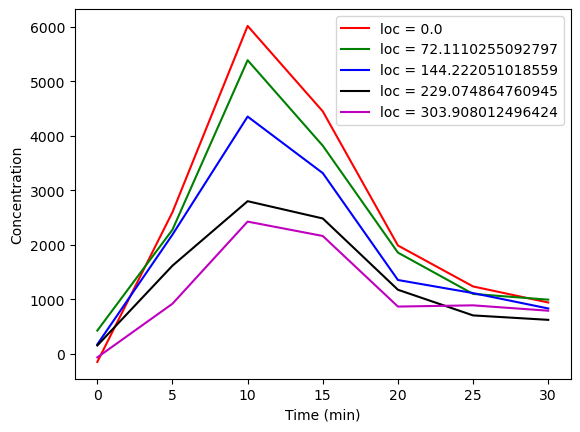

In [190]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cuqi.distribution import Gaussian, JointDistribution, Laplace_diff, Cauchy_diff, GMRF
from cuqi.geometry import Continuous1D, KLExpansion, Discrete, MappedGeometry, Continuous2D, Image2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel, Model
from cuqi.sampler import CWMH, MetropolisHastings, pCN
from cuqi.array import CUQIarray
np.random.seed(1)


df_t_l = pd.read_excel('~/Documents/research_resources/brain_efflux/CT_example_20210120_m1_l.xlsx')
times = df_t_l.loc[range(7)]['time \ ROI'].values*60
times = times.astype(np.float64)
print(times)
locations = df_t_l.loc[7][['CA1', 'CA2', 'CA3', 'CA4', 'CA5']].values
locations = locations.astype(np.float64)
print(locations)

df = pd.read_csv('~/Documents/research_resources/brain_efflux/CT/20210120_m2_l_parsed.csv')
data = df.loc[range(7)][['CA1', 'CA2', 'CA3', 'CA4', 'CA5']].values.T
data = data.astype(np.float64)
print(data)


L = 400
n_grid = 50   # Number of solution nodes
h = L/(n_grid+1)   # Space step size
#grid = np.linspace(h, L-h, n_grid)
#grid_c = np.linspace(0, L, n_grid+1, endpoint=True)

grid_c = np.linspace(0, L, n_grid+1, endpoint=True)
grid  = np.linspace(h, L-h, n_grid)

tau_max = 30*60 # Final time in sec
cfl = 5 # The cfl condition to have a stable solution
         # the method is implicit, we can choose relativley large time steps 
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)

# Source term
def g(c, tau_current):
    f_array = np.zeros(n_grid)
    f_array[0] = c[0]/h**2*100*np.interp(tau_current, times, data.reshape([len(locations), len(times)])[0,:])
    return f_array

#*np.sin(np.pi*tau_current/tau_max)


Dx = - np.diag(np.ones(n_grid), 0)+ np.diag(np.ones(n_grid-1), 1) #Dx
vec = np.zeros(n_grid)
vec[0] = 1
Dx = np.concatenate([vec.reshape([1, -1]), Dx], axis=0)
Dx /= h # FD derivative matrix

D_c = lambda c: - Dx.T @ np.diag(c) @ Dx

#D_c = lambda c: c * ( np.diag(-2*np.ones(n_grid), 0) +
#np.diag(np.ones(n_grid-1), -1) +
#np.diag(np.ones(n_grid-1), 1) ) / h**2

initial_condition = np.zeros(n_grid) 

def PDE_form(c, tau_current):
    return (D_c(c), g(c, tau_current), initial_condition)

#grid_obs = np.array([10, 72.11102551, 144.222051, 229.0748648, 303.9080125])
#time_obs = np.array([0, 5*60, 10*60, 15*60, 20*60, 25*60, 30*60])
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid,
                             method='backward_euler', 
                             grid_obs=locations,
                            time_obs=times) 


# Domain geometry
G_D =  MappedGeometry( Continuous1D(grid_c),  map=lambda x: x**2 )

# Range geometry
G_cont2D = Continuous2D((locations, times))

A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_D)

gamma = Gaussian(0, 1)
#x = Gaussian(np.sqrt(400), np.ones(G_D.par_dim)*100, geometry=G_D)3
#x = Cauchy_diff(0, 1, geometry=G_D)
x =  GMRF( np.ones(G_D.par_dim),2, geometry=G_D, bc_type='neumann')#GMRF( np.ones(G_D.par_dim), 1, geometry=G_D)
#LMRF(x_zero, scale=0.002)
x.name
s_noise = 0.1 \
          *np.linalg.norm(data) \
          *np.sqrt(1/G_cont2D.par_dim) 
y = Gaussian(A(x), s_noise**2, geometry=G_cont2D)

# Plot data 
color = ['r', 'g', 'b', 'k', 'm']
legends = ['loc = '+str(obs) for obs in locations]
lines = []
for i in range(len(locations)):
    #plt.figure()
    lines.append(plt.plot(times/60, data[i,:],  color=color[i])[0])
    #plt.plot(times/60, data[i,:], 'o', color=color[i])
    #plt.title('loc = '+str(i))

plt.legend(lines, legends)
plt.xlabel('Time (min)')
plt.ylabel('Concentration')

joint = JointDistribution(x, y)
joint

data = CUQIarray(data.ravel(), geometry=G_cont2D)
posterior = joint(y=data) # condition on y=y_obs
posterior

my_sampler = CWMH(posterior, scale=20, x0=20*np.ones(G_D.par_dim))

Ns = 5000  # funval of mean is about 587.25403559
posterior_samples = my_sampler.sample_adapt(Ns)


 None,

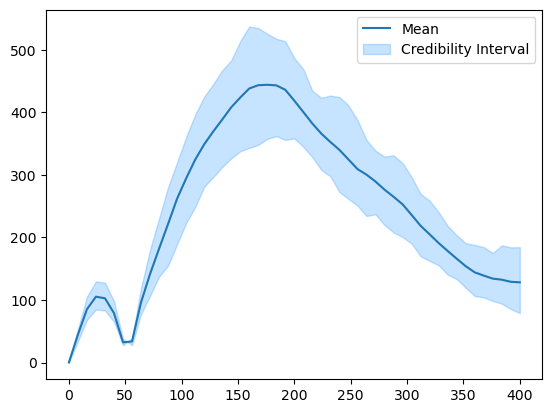

In [198]:
posterior_samples.burnthin(int(Ns*0.9)).plot_ci()

Text(0, 0.5, 'Concentration')

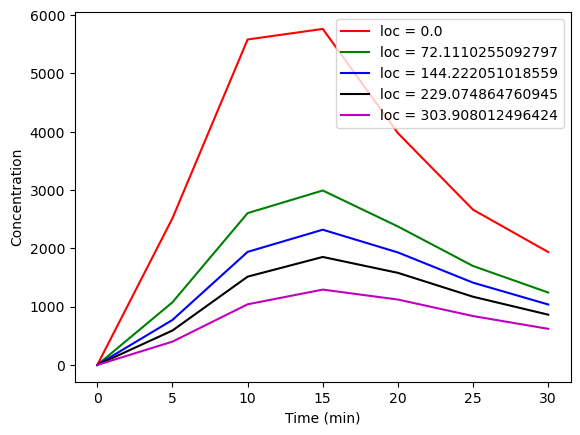

In [197]:
#mean_data = y(x = posterior_samples.burnthin(int(Ns*0.5)).mean()).sample() 
mean_data = A(posterior_samples.burnthin(int(Ns*0.9)).mean())
mean_data = mean_data.reshape([len(locations), len(times)])
# Plot data
color = ['r', 'g', 'b', 'k', 'm']
legends = ['loc = '+str(obs) for obs in locations]
lines = []
for i in range(len(locations)):
    lines.append(plt.plot(times/60, mean_data[i,:],  color=color[i])[0])


plt.legend(lines, legends)
plt.xlabel('Time (min)')
plt.ylabel('Concentration')

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'v4'}>,
        <AxesSubplot: title={'center': 'v4'}>],
       [<AxesSubplot: title={'center': 'v10'}>,
        <AxesSubplot: title={'center': 'v10'}>],
       [<AxesSubplot: title={'center': 'v15'}>,
        <AxesSubplot: title={'center': 'v15'}>],
       [<AxesSubplot: title={'center': 'v18'}>,
        <AxesSubplot: title={'center': 'v18'}>],
       [<AxesSubplot: title={'center': 'v29'}>,
        <AxesSubplot: title={'center': 'v29'}>]], dtype=object)

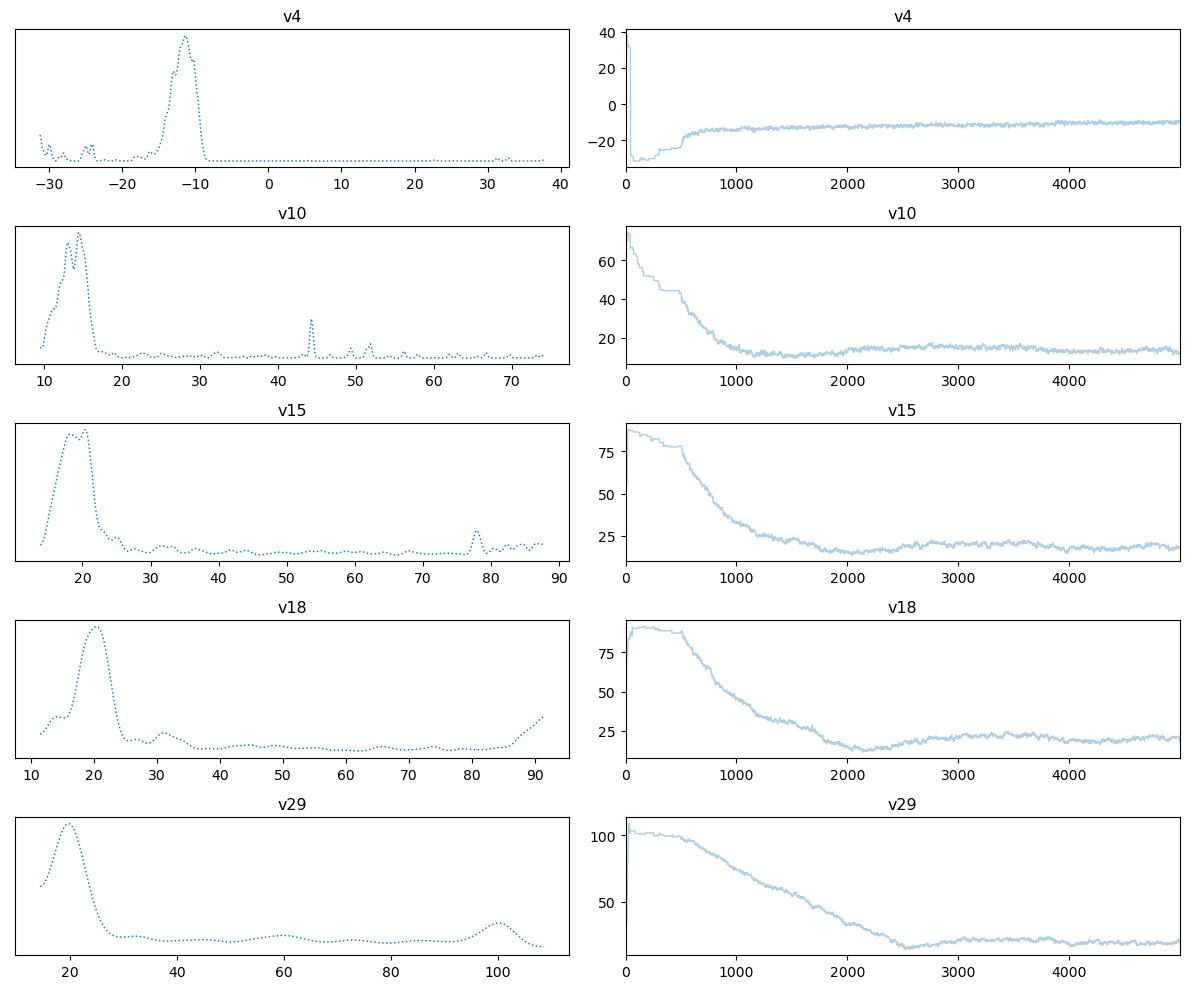

In [199]:
posterior_samples.plot_trace()